In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/Users/willwolf/Documents/willwolf/dotify


In [3]:
# delete this eventually

import os

os.environ['SQLALCHEMY_DATABASE_URI'] = os.environ['DIGITAL_OCEAN_SQLALCHEMY_DATABASE_URI']

In [24]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sqlalchemy import create_engine

from dotify.config import DevelopmentConfig as Config
from dotify.recommendation.implicit_mf.ratings_matrix import RatingsMatrix
from dotify.recommendation.implicit_mf.implicit_mf import ImplicitMF

ENGINE = create_engine(Config.SQLALCHEMY_DATABASE_URI)

%matplotlib inline

In [28]:
ratings_matrix = RatingsMatrix(n_top_songs=10000)

In [36]:
# split into train, test sets

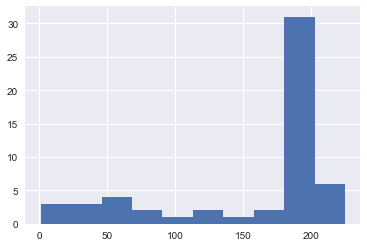

In [45]:
(ratings_matrix.R_ui > 0).sum(axis=1).hist()

In [63]:
np.percentile((ratings_matrix.R_ui > 0).sum(axis=1), 75)

201.0

In [65]:
more_than_50_ratings = (ratings_matrix.R_ui > 0).sum(axis=1) > 50

In [110]:
FRACTION_TO_DROP = .2
TRAIN_SET = ratings_matrix.R_ui

ratings_by_country_id = TRAIN_SET.ix[more_than_50_ratings].T.to_dict()
train_set_rated_songs = {
    country_id: {song for song, rating in ratings_by_country_id[country_id].items() if rating > 0} \
        for country_id in ratings_by_country_id
}

validation_set = {}
for country_id in train_set_rated_songs:
    rated_songs = train_set_rated_songs[country_id]
    nb_items_to_drop = int( len(rated_songs)*FRACTION_TO_DROP )
    validation_set_rated_songs = set( random.sample(rated_songs, nb_items_to_drop) )
    
    validation_set[country_id] = validation_set_rated_songs
    train_set_rated_songs[country_id] -= validation_set_rated_songs
    TRAIN_SET.ix[country_id][validation_set_rated_songs] = 0.

In [ ]:
F = 30
ALPHA = 1
LAMBDA = 25

In [ ]:
implicit_mf = ImplicitMF(ratings_matrix=RatingsMatrix(), f=F, alpha=ALPHA, lmbda=LAMBDA)

In [ ]:
print(implicit_mf.country_vectors.vectors.shape)
print(implicit_mf.song_vectors.vectors.shape)

In [ ]:
implicit_mf.run()

In [ ]:
# implicit_mf.country_vectors.vectors.to_csv('data/country_vectors.csv')
# implicit_mf.song_vectors.vectors.to_csv('data/song_vectors.csv')
implicit_mf.country_vectors.vectors = pd.read_csv('data/country_vectors.csv', index_col=['country_id'])
implicit_mf.song_vectors.vectors = pd.read_csv('data/song_vectors.csv', index_col=['song_id'])

In [ ]:
# make the names shorter

In [ ]:
country_vectors_df = implicit_mf.country_vectors.vectors
song_vectors_df = implicit_mf.song_vectors.vectors

## Visualize

In [ ]:
country_vectors_df.head()

In [ ]:
song_vectors_df.head()

In [ ]:
# change countries index form id to name

In [ ]:
sns.set(style="white")

In [ ]:
from dotify.resources.countries import countries as countries_lookup


country_id_to_name = {countries_lookup[name]['id']: name for name in countries_lookup}


def replace_country_id_index_with_country_names(df):
    country_ids = df.index
    df.index = pd.Index([country_id_to_name[c_id] for c_id in country_ids], name='country_name')
    return df


country_ids = country_vectors_df.index
country_names = pd.Index([country_id_to_name[c_id] for c_id in country_ids], name='country_name')
country_vectors_df.index = country_names

In [ ]:
def plot_cosine_similarities(country_vectors_df):

    # compute the cosine similarity matrix
    similarities_df = pd.DataFrame(
        data=cosine_similarity(country_vectors_df),
        index=country_vectors_df.index,
        columns=country_vectors_df.index
    )
    
    # generate a mask for the upper triangle
    mask = np.zeros_like(similarities_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(21, 21))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(similarities_df, mask=mask, cmap=cmap, vmax=.5,
                square=True, xticklabels=True, yticklabels=True,
                linewidths=1, cbar_kws={"shrink": .5}, ax=ax)

In [ ]:
plot_cosine_similarities(country_vectors_df)

# tsne

In [ ]:
from matplotlib import pylab
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [ ]:
country_embeddings = pd.DataFrame(
    data=tsne.fit_transform(country_vectors_df),
    index=country_vectors_df.index,
    columns=['dim_1', 'dim_2']
)

In [ ]:
def plot_tsne_embeddings(country_embeddings):

    pylab.figure(figsize=(15,15))

    for country_name, country_embedding in country_embeddings.iterrows():
        dim_1, dim_2 = country_embedding
        pylab.scatter(dim_1, dim_2)
        pylab.annotate(country_name, xy=(dim_1, dim_2), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

In [ ]:
plot_tsne_embeddings(country_embeddings)

## Inspect arithmetic combinations

In [ ]:
SONG_VECTORS_QUERY = """
    SELECT 
        songs.title as song_title, 
        songs.artist as song_artist,
        song_vectors.* 
    FROM song_vectors 
    JOIN songs ON songs.id = song_vectors.song_id
"""

song_vectors_df = pd.read_sql(SONG_VECTORS_QUERY, ENGINE, index_col=['song_title', 'song_artist'])
song_vectors_df.drop('song_id', axis=1, inplace=True)

In [ ]:
country_vec = country_vectors_df.ix['United States']

In [ ]:
song_vectors_df.apply(lambda vec: np.dot(vec, country_vec), axis=1).sort_values(ascending=False).head(10)

In [ ]:
country_vec = country_vectors_df.ix['Colombia']

In [ ]:
song_vectors_df.apply(lambda vec: np.dot(vec, country_vec), axis=1).sort_values(ascending=False).head(10)

In [ ]:
country_vec = country_vectors_df.ix['France']

In [ ]:
song_vectors_df.apply(lambda vec: np.dot(vec, country_vec), axis=1).sort_values(ascending=False).head(10)